## **Loading lib**

In [1]:
# %%capture
# !pip install osmnx
# !pip install geopandas
# !pip install shapely
# !pip install fuzzywuzzy
# !pip install folium
# !pip install requests
# !pip install mapclassify
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install torch_geometric

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import time
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length
import osmnx as ox
from typing import Dict, Tuple, List, Optional, Type, Any, Union

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from queue import PriorityQueue
import heapq

import geopandas as gpd
from shapely.geometry import Point
from fuzzywuzzy import process
import folium

import requests
import random
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings
warnings.filterwarnings('ignore')

# Adding this if running on Colab
# from google.colab import files, drive
# drive.mount('/content/drive')
import os

d:\ANACONDA3\envs\research_v1\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## **Function downloading data**





In [3]:
import numpy as np
import torch
import osmnx as ox
import requests
import time
import random
import networkx as nx
import pandas as pd
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from typing import Tuple, Dict, Any

def download_street_network(place_name: str, network_type: str = 'drive') -> nx.MultiDiGraph:
    """
    Downloads the street network for the specified place and network type.

    Parameters
    ----------
    place_name : str
        The name of the place for which to download the street network.
    network_type : str, optional
        The type of street network to download (e.g., 'drive', 'walk'), by default 'drive'.

    Returns
    -------
    nx.MultiDiGraph
        A NetworkX MultiDiGraph representing the downloaded street network with edge lengths.
    """
    print(f"Downloading street network for {place_name}...")
    G = ox.graph_from_place(place_name, network_type=network_type, simplify=True)
    print("Street network downloaded.")

    if not all('length' in data for _, _, data in G.edges(data=True)):
        print("Adding edge lengths...")
        G = ox.add_edge_lengths(G)
        print("Edge lengths added.")
    else:
        print("All edges have 'length' attribute.")

    return G

def create_robust_session() -> requests.Session:
    """
    Creates a robust session for making HTTP requests with retries, backoff, and a custom User-Agent.

    Returns
    -------
    requests.Session
        A configured Session object with retry strategy.
    """
    session = requests.Session()
    retry = Retry(
        total=5,
        backoff_factor=0.1,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET", "OPTIONS"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    session.headers.update({'User-Agent': 'YourAppName/1.0'})  # Customize as needed
    return session

def get_place_name(lat: float, lon: float, session: requests.Session) -> str:
    """
    Fetches the place name for given coordinates using OpenStreetMap's Nominatim API.

    Parameters
    ----------
    lat : float
        Latitude of the location.
    lon : float
        Longitude of the location.
    session : requests.Session
        A robust session object for making HTTP requests.

    Returns
    -------
    str
        The name of the place corresponding to the provided coordinates, or 'Unknown' if not found.
    """
    url = (
        f"https://nominatim.openstreetmap.org/reverse?"
        f"format=json&lat={lat}&lon={lon}&zoom=18&addressdetails=1"
    )
    try:
        time.sleep(random.uniform(1, 2))  # Respectful delay between requests
        response = session.get(url)
        response.raise_for_status()
        data = response.json()
        return data.get('name', 'Unknown')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching place name for coordinates ({lat}, {lon}): {e}")
        return 'Unknown'

def assign_weights_to_edges(G: nx.MultiDiGraph, edges_csv: str = 'district1_edges.csv') -> nx.MultiDiGraph:
    """
    Ensures all edges have a 'weight' attribute, assigning it based on 'length' or a default value.

    Parameters
    ----------
    G : nx.MultiDiGraph
        The graph whose edges need weight assignment.
    edges_csv : str, optional
        The path to the CSV file containing edge information, by default 'district1_edges.csv'.

    Returns
    -------
    nx.MultiDiGraph
        The updated graph with all edges containing a 'weight' attribute.
    """
    print("Assigning 'weight' to edges...")
    edges_without_weight = [
        (u, v, k) for u, v, k, data in G.edges(keys=True, data=True) if 'weight' not in data
    ]
    print(f"Number of edges without 'weight': {len(edges_without_weight)}")

    for u, v, k in edges_without_weight:
        edge_data = G[u][v][k]
        G[u][v][k]['weight'] = edge_data.get('length', 1)  # Assign 'length' or default to 1

    print("All edges have 'weight' attribute.")
    return G

def check_consistent_node_ids(G: nx.MultiDiGraph) -> nx.MultiDiGraph:
    """
    Converts node IDs to integers if they are floats representing whole numbers.

    Parameters
    ----------
    G : nx.MultiDiGraph
        The graph whose node IDs need to be checked for consistency.

    Returns
    -------
    nx.MultiDiGraph
        The updated graph with consistent node ID data types.
    """
    print("Checking consistent node ID data types...")
    mapping: Dict[Any, Any] = {}
    for node in G.nodes():
        if isinstance(node, float) and node.is_integer():
            mapping[node] = int(node)

    if mapping:
        G = nx.relabel_nodes(G, mapping, copy=False)
        print(f"Relabeled {len(mapping)} nodes from float to int.")
    else:
        print("No relabeling needed. All node IDs are consistent.")

    return G

def extract_nodes_edges_to_csv(
    G: nx.MultiDiGraph,
    nodes_csv: str = 'district1_nodes.csv',
    edges_csv: str = 'district1_edges.csv'
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Extracts nodes and edges from the graph, adds place names, and saves them to CSV files.
    Includes one-way road information for edges.

    Parameters
    ----------
    G : nx.MultiDiGraph
        The graph from which to extract nodes and edges.
    nodes_csv : str, optional
        The path to the CSV file where node information will be saved, by default 'district1_nodes.csv'.
    edges_csv : str, optional
        The path to the CSV file where edge information will be saved, by default 'district1_edges.csv'.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        A tuple containing the nodes DataFrame and edges DataFrame.
    """
    print("Extracting nodes and edges...")
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # Prepare nodes DataFrame
    nodes_df = nodes.reset_index()
    nodes_df.rename(columns={'osmid': 'node_id'}, inplace=True)

    if 'x' not in nodes_df.columns or 'y' not in nodes_df.columns:
        nodes_df['x'] = nodes_df.geometry.x
        nodes_df['y'] = nodes_df.geometry.y

    # Add degree for each node
    nodes_df['degree'] = nodes_df['node_id'].map(dict(G.degree()))

    # Add place names
    print("Fetching place names for nodes (this may take some time)...")
    session = create_robust_session()
    nodes_df['place_name'] = nodes_df.apply(
        lambda row: get_place_name(row['y'], row['x'], session), axis=1
    )
    print("Place names added.")

    # Save nodes to CSV
    nodes_df.to_csv(nodes_csv, index=False)
    print(f"Nodes saved to '{nodes_csv}'.")

    # Prepare edges DataFrame
    edges_df = edges.reset_index()
    edges_df.rename(columns={'u': 'source', 'v': 'target'}, inplace=True)

    # Include one-way information
    edges_df['oneway'] = edges_df['oneway'].fillna(False)  # Default to False if not specified

    # Select relevant columns
    edges_df = edges_df[['source', 'target', 'length', 'oneway']]

    # Save edges to CSV
    edges_df.to_csv(edges_csv, index=False)
    print(f"Edges saved to '{edges_csv}'.")

    return nodes_df, edges_df

def prepare_directed_adjacency_matrix(edges_df: pd.DataFrame) -> Tuple[torch.FloatTensor, Dict]:
    """
    Prepare a square adjacency matrix from the edges DataFrame, accounting for one-way roads.

    Parameters
    ----------
    edges_df : pd.DataFrame
        DataFrame containing edge information with 'source', 'target', and 'oneway' columns.

    Returns
    -------
    torch.FloatTensor
        Adjacency matrix representing the directed edges.
    Dict
        Mapping from node identifiers to their corresponding indices in the adjacency matrix.
    """
    all_nodes = set(edges_df['source']).union(set(edges_df['target']))
    n = len(all_nodes)
    node_to_index = {node: i for i, node in enumerate(all_nodes)}

    adjacency_matrix = np.zeros((n, n))
    for _, row in edges_df.iterrows():
        i, j = node_to_index[row['source']], node_to_index[row['target']]
        adjacency_matrix[i, j] = 1
        if not row['oneway']:
            adjacency_matrix[j, i] = 1

    return torch.FloatTensor(adjacency_matrix), node_to_index

def prepare_weighted_directed_adjacency_matrix(edges_df: pd.DataFrame) -> Tuple[torch.FloatTensor, Dict]:
    """
    Prepare a square adjacency matrix from the edges DataFrame, accounting for one-way roads
    and incorporating edge weights (lengths).

    Parameters
    ----------
    edges_df : pd.DataFrame
        DataFrame containing edge information with 'source', 'target', 'oneway', and 'length' columns.

    Returns
    -------
    torch.FloatTensor
        Weighted adjacency matrix representing the directed edges.
    Dict
        Mapping from node identifiers to their corresponding indices in the adjacency matrix.
    """
    all_nodes = set(edges_df['source']).union(set(edges_df['target']))
    n = len(all_nodes)
    node_to_index = {node: i for i, node in enumerate(all_nodes)}

    adjacency_matrix = np.zeros((n, n))
    for _, row in edges_df.iterrows():
        i, j = node_to_index[row['source']], node_to_index[row['target']]
        adjacency_matrix[i, j] = row['length']
        if not row['oneway']:
            adjacency_matrix[j, i] = row['length']

    return torch.FloatTensor(adjacency_matrix), node_to_index

def prepare_feature_matrix(nodes_df: pd.DataFrame, node_to_index: Dict) -> torch.FloatTensor:
    """
    Prepare the feature matrix using latitude, longitude, and degree.

    Parameters
    ----------
    nodes_df : pd.DataFrame
        DataFrame containing node information with 'node_id', 'y', 'x', and 'degree' columns.
    node_to_index : Dict
        Mapping from node identifiers to their corresponding indices in the feature matrix.

    Returns
    -------
    torch.FloatTensor
        Feature matrix where each row corresponds to a node's [latitude, longitude, degree].
    """
    n = len(node_to_index)
    feature_matrix = np.zeros((n, 3))

    for _, row in nodes_df.iterrows():
        if row['node_id'] in node_to_index:
            i = node_to_index[row['node_id']]
            feature_matrix[i] = [row['y'], row['x'], row['degree']]

    return torch.FloatTensor(feature_matrix)

## **Downloading data**

In [4]:
# Define the area of interest
place_name = "District 1, Ho Chi Minh City, Vietnam"
network_type = 'drive'

# Download the street network
G = ox.graph_from_place(place_name, network_type=network_type)

# Ensure edge lengths are calculated
if not all('length' in data for u, v, data in G.edges(data=True)):
    G = ox.add_edge_lengths(G)

# Extract edges with one-way information
edges = []
for u, v, data in G.edges(data=True):
    edge = {
        'source': u,
        'target': v,
        'length': data['length'],
        'oneway': data.get('oneway', False)  # Default to False if not specified
    }
    edges.append(edge)

edges_df = pd.DataFrame(edges)

## **Reading data and preprocess**

In [5]:
# data_path = 'drive/MyDrive/data/GNN_shortest_path'
data_path = 'data'

nodes_df = pd.read_csv(os.path.join(data_path, 'district1_nodes_full.csv'),
                       index_col=0)
nodes_df = nodes_df[nodes_df['node_id'].isin(edges_df['target'])]

nodes_df = nodes_df.dropna(subset="place_name")
edges_df = edges_df[edges_df['target'].isin(nodes_df['node_id'])]

## **Prepare adjacency matrix and feature matrix, normalized**

In [6]:
# Prepare adjacency matrix and feature matrix
adjacency_matrix, node_to_index = prepare_directed_adjacency_matrix(edges_df)
feature_matrix = prepare_feature_matrix(nodes_df, node_to_index)

feature_matrix = feature_matrix.numpy()

latitude = feature_matrix[:, 0]
longitude = feature_matrix[:, 1]
degree = feature_matrix[:, 2]

latitude_rad = np.deg2rad(latitude)
longitude_rad = np.deg2rad(longitude)
lat_sin = np.sin(latitude_rad)
lat_cos = np.cos(latitude_rad)
lon_sin = np.sin(longitude_rad)
lon_cos = np.cos(longitude_rad)
degree_log = np.log(degree + 1)

features_transformed = np.stack((lat_sin, lat_cos, lon_sin, lon_cos, degree_log), axis=1)

# Normalize along column
means = features_transformed.mean(axis=0)
stds = features_transformed.std(axis=0)
features_normalized = (features_transformed - means) / stds


features_normalized = torch.tensor(features_normalized, dtype=torch.float32)

## **Full Pathfinding Algorithms**

### **Utility**

In [7]:
def compute_normalized_laplacian(adj_matrix):
    """
    Computes the normalized Laplacian matrix.

    Args:
        adj_matrix (torch.Tensor): Adjacency matrix of shape [num_nodes, num_nodes].

    Returns:
        torch.sparse_coo_tensor: Normalized Laplacian matrix.
    """
    # Degree matrix
    degree = torch.sparse.sum(adj_matrix, dim=1).to_dense()  # Shape: [num_nodes]
    degree_inv_sqrt = torch.pow(degree, -0.5)
    degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0.0

    # D^{-0.5} as a diagonal matrix
    D_inv_sqrt = torch.diag(degree_inv_sqrt)  # Shape: [num_nodes, num_nodes]

    # Convert sparse adjacency to dense for multiplication
    adj_dense = adj_matrix.to_dense()  # Shape: [num_nodes, num_nodes]

    # Normalized Laplacian: I - D^{-0.5} * A * D^{-0.5}
    num_nodes = adj_matrix.shape[0]
    identity = torch.eye(num_nodes)
    normalized_laplacian = identity - D_inv_sqrt @ adj_dense @ D_inv_sqrt

    # Convert back to sparse
    return normalized_laplacian.to_sparse()

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def find_node_index(node_id_place_name, value):
    for key, val in node_id_place_name.items():
        if val == value:
            k = int(key)
            for key, val in node_to_index.items():
                if val == k:
                    return val
    return "None"

def visualize_k_shortest_paths(k_shortest_paths,
                               index_to_node_id,
                               node_id_to_coords,
                               node_id_to_name,
                               map_html='k_shortest_paths_map.html'):
    """
    Visualizes the K-shortest paths on an interactive Folium map.

    Args:
        k_shortest_paths (list): List of tuples (cost, path_indices), where path_indices are node indices.
        index_to_node_id (dict): Mapping from node indices to node IDs.
        node_id_to_coords (dict): Mapping from node IDs to (latitude, longitude).
        node_id_to_name (dict): Mapping from node IDs to place names.
        map_html (str): Output HTML file name for the map.
    """
    print("Visualizing K-shortest paths...")

    # Initialize Folium map centered around the first node in the first path
    first_index = k_shortest_paths[0][1][0]
    first_node_id = index_to_node_id[first_index]
    first_coords = node_id_to_coords[first_node_id]
    m = folium.Map(location=first_coords, zoom_start=15)

    # Define colors for different paths
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for idx, (cost, path_indices) in enumerate(k_shortest_paths):
        # Convert node indices to node IDs
        node_ids = [index_to_node_id[index] for index in path_indices]

        # Extract latitude and longitude for each node in the path
        path_coords = [node_id_to_coords[node_id] for node_id in node_ids]

        # Add polyline to the map
        folium.PolyLine(
            locations=path_coords,
            color=colors[idx % len(colors)],
            weight=5,
            opacity=0.7,
            popup=f'Path {idx+1}: Cost {cost:.2f}'
        ).add_to(m)

        # add markers for start and end points
        if idx == 0:
            # Start point
            folium.Marker(
                location=path_coords[0],
                popup=f"Start: {node_id_to_name.get(node_ids[0], 'Start Node')}",
                icon=folium.Icon(color='green', icon='play')
            ).add_to(m)
            # End point
            folium.Marker(
                location=path_coords[-1],
                popup=f"End: {node_id_to_name.get(node_ids[-1], 'End Node')}",
                icon=folium.Icon(color='red', icon='stop')
            ).add_to(m)

    # Save the map to an HTML file
    m.save(map_html)
    print(f"K-shortest paths map saved as '{map_html}'. Open it in a web browser to view.")

def generate_random_graph(num_nodes, directed=False, edge_prob=0.3,
                          weight_range=(1, 10)):
    """
    Generates a random graph represented as an adjacency matrix.

    Args:
        num_nodes (int): Number of nodes in the graph.
        directed (bool, optional): Whether the graph is directed. Defaults to False.
        edge_prob (float, optional): Probability of edge creation between nodes. Defaults to 0.3.
        weight_range (tuple, optional): Range of edge weights. Defaults to (1, 10).

    Returns:
        np.ndarray: Adjacency matrix of shape [num_nodes, num_nodes].
    """
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue  # No self-loops
            if random.random() < edge_prob:
                weight = random.uniform(*weight_range)
                adj_matrix[i][j] = weight
                if not directed:
                    adj_matrix[j][i] = weight
    return adj_matrix

def generate_connected_random_graph(num_nodes, directed=False,
                                    edge_prob=0.3, weight_range=(1, 10)):
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    # Ensure connectivity by creating a random spanning tree
    for i in range(1, num_nodes):
        j = random.randint(0, i-1)
        weight = random.uniform(*weight_range)
        adj_matrix[i][j] = weight
        if not directed:
            adj_matrix[j][i] = weight

    # Add additional random edges
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if random.random() < edge_prob:
                weight = random.uniform(*weight_range)
                adj_matrix[i][j] = weight
                if not directed:
                    adj_matrix[j][i] = weight

    return adj_matrix

def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.

    Args:
        seed (int, optional): Seed value. Defaults to 42.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

### **Yen's algorithm networkx**

In [8]:
def yen_top_k_shortest_paths(adjacency_matrix, source, target, K):
    """
    Finds the top K shortest paths from source to target using Yen's algorithm.

    Args:
        adjacency_matrix (np.ndarray): Adjacency matrix with edge weights.
        source (int): Source node index.
        target (int): Target node index.
        K (int): Number of shortest paths to find.

    Returns:
        list: List of tuples (total_cost, path) where path is a list of node indices.
    """
    G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph())
    for u, v, data in G.edges(data=True):
        data['weight'] = adjacency_matrix[u, v]  # Assign edge weights

    try:
        paths = nx.shortest_simple_paths(G, source, target, weight='weight')
    except nx.NetworkXNoPath:
        return []

    top_k_paths = []
    for path in paths:
        total_cost = sum(G[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
        top_k_paths.append((total_cost, path))
        if len(top_k_paths) == K:
            break

    return top_k_paths


### **GCN**

In [9]:
class GCNLayer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int = 1, normalization: str = "sym") -> None:
        """
        Initializes the GCNLayer.

        Parameters
        ----------
        input_dim : int
            Dimensionality of input features.
        output_dim : int, optional
            Dimensionality of output features, by default 1.
        normalization : str, optional
            Type of normalization ('sym' for symmetric, 'rw' for random walk), by default "sym".
        
        Raises
        ------
        ValueError
            If an invalid normalization type is provided.
        """
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.normalization = normalization
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, adj_matrix: torch.sparse.FloatTensor, feature_matrix: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCNLayer.

        Parameters
        ----------
        adj_matrix : torch.sparse.FloatTensor
            Sparse adjacency matrix of shape [num_nodes, num_nodes].
        feature_matrix : torch.Tensor
            Feature matrix of shape [num_nodes, input_dim].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, output_dim].
        """
        # Ensure adjacency matrix is sparse and coalesced
        if not adj_matrix.is_sparse:
            adj_matrix = adj_matrix.to_sparse()
        else:
            adj_matrix = adj_matrix.coalesce()

        # Apply normalization
        if self.normalization == "sym":
            adj_normalized = self.symmetric_normalization(adj_matrix)
        elif self.normalization == "rw":
            adj_normalized = self.row_normalization(adj_matrix)
        else:
            raise ValueError("Invalid normalization type. Choose 'sym' or 'rw'.")

        # Perform the GCN operation: A_hat * X * W
        x = torch.sparse.mm(adj_normalized, feature_matrix)  # Shape: [num_nodes, input_dim]
        x = self.linear(x)  # Shape: [num_nodes, output_dim]
        return x

    def symmetric_normalization(self, adj: torch.sparse.FloatTensor) -> torch.sparse.FloatTensor:
        """
        Applies symmetric normalization: D^{-0.5} * A * D^{-0.5}.

        Parameters
        ----------
        adj : torch.sparse.FloatTensor
            Sparse adjacency matrix.

        Returns
        -------
        torch.sparse.FloatTensor
            Symmetrically normalized adjacency matrix.
        """
        # D^{-0.5}
        degree = torch.sparse.sum(adj, dim=1).to_dense()  # Shape: [num_nodes]
        degree_inv_sqrt = torch.pow(degree, -0.5)
        degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0.0  # Handle division by zero

        # D^{-0.5} as a diagonal matrix
        D_inv_sqrt = torch.diag(degree_inv_sqrt)  # Shape: [num_nodes, num_nodes]

        # Convert sparse adjacency to dense for multiplication
        adj_dense = adj.to_dense()  # Shape: [num_nodes, num_nodes]

        # Apply symmetric normalization: D^{-0.5} * A * D^{-0.5}
        adj_normalized = D_inv_sqrt @ adj_dense @ D_inv_sqrt  # Shape: [num_nodes, num_nodes]

        # Convert back to sparse
        return adj_normalized.to_sparse()

    def row_normalization(self, adj: torch.sparse.FloatTensor) -> torch.sparse.FloatTensor:
        """
        Applies random walk normalization: D^{-1} * A.

        Parameters
        ----------
        adj : torch.sparse.FloatTensor
            Sparse adjacency matrix.

        Returns
        -------
        torch.sparse.FloatTensor
            Row-normalized adjacency matrix.
        """
        # Calculate D^{-1}
        degree = torch.sparse.sum(adj, dim=1).to_dense()  # Shape: [num_nodes]
        degree_inv = torch.pow(degree, -1)
        degree_inv[torch.isinf(degree_inv)] = 0.0  # Handle division by zero

        # Create D^{-1} as a diagonal matrix
        D_inv = torch.diag(degree_inv)  # Shape: [num_nodes, num_nodes]

        # Convert sparse adjacency to dense for multiplication
        adj_dense = adj.to_dense()  # Shape: [num_nodes, num_nodes]

        # Apply row normalization: D^{-1} * A
        adj_normalized = D_inv @ adj_dense  # Shape: [num_nodes, num_nodes]

        # Convert back to sparse
        return adj_normalized.to_sparse()

class ResidualGCNLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, normalization: str = "sym") -> None:
        """
        Initializes the ResidualGCNLayer.

        Parameters
        ----------
        in_features : int
            Number of input features.
        out_features : int
            Number of output features.
        normalization : str, optional
            Type of normalization ('sym' for symmetric, 'rw' for random walk), by default "sym".
        """
        super(ResidualGCNLayer, self).__init__()
        self.gcn = GCNLayer(in_features, out_features, normalization)
        self.relu = nn.ReLU()
        if in_features != out_features:
            self.residual = nn.Linear(in_features, out_features)
        else:
            self.residual = nn.Identity()

    def forward(self, adj_matrix: torch.sparse.FloatTensor, feature_matrix: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResidualGCNLayer.

        Parameters
        ----------
        adj_matrix : torch.sparse.FloatTensor
            Sparse adjacency matrix of shape [num_nodes, num_nodes].
        feature_matrix : torch.Tensor
            Feature matrix of shape [num_nodes, in_features].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, out_features].
        """
        identity = self.residual(feature_matrix)
        out = self.gcn(adj_matrix, feature_matrix)
        return self.relu(out + identity)

class StackGCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        dropout: float = 0.1,
        normalization: str = "sym",
        num_layers: int = 2,
        residual: bool = True
    ) -> None:
        """
        Initializes the StackGCN model.

        Parameters
        ----------
        input_dim : int
            Dimensionality of input features.
        hidden_dim : int
            Dimensionality of hidden layers.
        output_dim : int
            Dimensionality of the output layer.
        dropout : float, optional
            Dropout rate, by default 0.1.
        normalization : str, optional
            Type of normalization ('sym' for symmetric, 'rw' for random walk), by default "sym".
        num_layers : int, optional
            Number of GCN layers, by default 2. Must be at least 2.
        residual : bool, optional
            Whether to use residual connections, by default True.
        """
        super(StackGCN, self).__init__()

        self.residual = residual
        layers = []
        if num_layers < 2:
            num_layers = 2  # At least input and output layers

        # Input layer
        layers.append(GCNLayer(input_dim, hidden_dim, normalization=normalization))
        # Hidden layers
        for _ in range(num_layers - 2):
            if residual:
                layers.append(ResidualGCNLayer(hidden_dim, hidden_dim, normalization=normalization))
            else:
                layers.append(GCNLayer(hidden_dim, hidden_dim, normalization=normalization))
        # Output layer
        layers.append(GCNLayer(hidden_dim, output_dim, normalization=normalization))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self) -> None:
        """
        Initializes weights of the GCN layers using Xavier uniform initialization.
        """
        for layer in self.layers:
            if isinstance(layer, GCNLayer):
                nn.init.xavier_uniform_(layer.linear.weight)
            elif isinstance(layer, ResidualGCNLayer):
                nn.init.xavier_uniform_(layer.gcn.linear.weight)
                if isinstance(layer.residual, nn.Linear):
                    nn.init.xavier_uniform_(layer.residual.weight)

    def forward(self, adj_matrix: torch.sparse.FloatTensor, feature_matrix: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the StackGCN model.

        Parameters
        ----------
        adj_matrix : torch.sparse.FloatTensor
            Sparse adjacency matrix of shape [num_nodes, num_nodes].
        feature_matrix : torch.Tensor
            Feature matrix of shape [num_nodes, input_dim].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, output_dim].
        """
        x = self.dropout(feature_matrix)
        for i, layer in enumerate(self.layers):
            x = layer(adj_matrix, x)
            if i < len(self.layers) - 1:
                if not self.residual or not isinstance(layer, ResidualGCNLayer):
                    x = self.relu(x)
                x = self.dropout(x)
        return x

### **Chebysev GCN**

In [10]:
class ChebNetConv(nn.Module):
    def __init__(self, in_features: int, out_features: int, k: int) -> None:
        """
        Initializes the Chebyshev Convolution Layer.

        Parameters
        ----------
        in_features : int
            Number of input features per node.
        out_features : int
            Number of output features per node.
        k : int
            Chebyshev polynomial order.
        """
        super(ChebNetConv, self).__init__()
        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(
        self, 
        x: torch.Tensor, 
        laplacian: torch.sparse_coo_tensor
    ) -> torch.Tensor:
        """
        Forward pass of the ChebNetConv layer.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape [num_nodes, in_features].
        laplacian : torch.sparse_coo_tensor
            Scaled Laplacian matrix of shape [num_nodes, num_nodes].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, out_features].
        """
        if not laplacian.is_sparse:
            laplacian = laplacian.to_sparse()
        cheb_x = self.__transform_to_chebyshev(x, laplacian)  # Shape: [num_nodes, in_features * K]
        x = self.linear(cheb_x)  # Shape: [num_nodes, out_features]
        return x

    def __transform_to_chebyshev(
        self, 
        x: torch.Tensor, 
        laplacian: torch.sparse_coo_tensor
    ) -> torch.Tensor:
        """
        Transforms the input features using Chebyshev polynomials.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape [num_nodes, in_features].
        laplacian : torch.sparse_coo_tensor
            Scaled Laplacian matrix.

        Returns
        -------
        torch.Tensor
            Transformed features of shape [num_nodes, in_features * K].
        """
        cheb_x = x.unsqueeze(2)  # Shape: [num_nodes, in_features, 1]
        x0 = x  # T0(x)
        cheb_x = x0.unsqueeze(2)  # Initialize with T0(x)
        if not laplacian.is_sparse:
            laplacian = laplacian.to_sparse()
        if self.K > 1:
            x1 = torch.sparse.mm(laplacian, x0)  # T1(x) = L * x0
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)  # Concatenate T1(x)
            for _ in range(2, self.K):
                x2 = 2 * torch.sparse.mm(laplacian, x1) - x0  # T_k(x) = 2 * L * T_{k-1}(x) - T_{k-2}(x)
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2  # Update T_{k-2} and T_{k-1}

        cheb_x = cheb_x.reshape([x.shape[0], -1])  # Flatten to [num_nodes, in_features * K]
        return cheb_x


class ChebNetGCN(nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        hidden_dim: int, 
        output_dim: int,
        num_hidden_layers: int = 0, 
        dropout: float = 0.1, 
        residual: bool = True, 
        k: int = 2
    ) -> None:
        """
        Initializes the ChebNetGCN model.

        Parameters
        ----------
        input_dim : int
            Number of input features per node.
        hidden_dim : int
            Number of hidden units.
        output_dim : int
            Number of output features per node.
        num_hidden_layers : int, optional
            Number of hidden ChebNetConv layers, by default 0.
        dropout : float, optional
            Dropout rate, by default 0.1.
        residual : bool, optional
            Whether to use residual connections, by default True.
        k : int, optional
            Chebyshev polynomial order, by default 2.
        """
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual
        self.k = k

        # Input layer
        self.input_conv = ChebNetConv(input_dim, hidden_dim, k)

        # Hidden layers
        self.hidden_convs = nn.ModuleList([
            ChebNetConv(hidden_dim, hidden_dim, k) for _ in range(num_hidden_layers)
        ])

        # Output layer
        self.output_conv = ChebNetConv(hidden_dim, output_dim, k)

        # Activation
        self.relu = nn.ReLU()

        # self._init_weights()

    def _init_weights(self) -> None:
        """
        Initializes weights of the ChebNetConv layers using Xavier uniform initialization.
        """
        for layer in self.hidden_convs:
            nn.init.xavier_uniform_(layer.linear.weight)
        nn.init.xavier_uniform_(self.input_conv.linear.weight)
        nn.init.xavier_uniform_(self.output_conv.linear.weight)

    def forward(
        self, 
        x: torch.Tensor, 
        laplacian: torch.sparse_coo_tensor,
        labels: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass of the ChebNetGCN model.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape [num_nodes, input_dim].
        laplacian : torch.sparse_coo_tensor
            Scaled Laplacian matrix.
        labels : torch.Tensor, optional
            Labels for nodes, by default None.

        Returns
        -------
        Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]
            If labels are provided, returns (output, loss).
            Otherwise, returns output.
        """
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.input_conv(x, laplacian)  # Shape: [num_nodes, hidden_dim]
        x = self.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        for conv in self.hidden_convs:
            if self.residual:
                x_residual = x
                x = conv(x, laplacian)
                x = self.relu(x + x_residual)
            else:
                x = conv(x, laplacian)
                x = self.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.output_conv(x, laplacian)  # Shape: [num_nodes, output_dim]

        if labels is not None:
            # For regression tasks, use MSELoss
            loss_fn = nn.MSELoss()
            loss = loss_fn(x, labels)
            return x, loss

        return x

### **GNN**

In [11]:
class StackGNN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        dropout: float = 0.1,
        normalization: str = "sym",
        num_layers: int = 2,
        residual: bool = True
    ) -> None:
        """
        Initializes the StackGNN model.

        Parameters
        ----------
        input_dim : int
            Number of input features per node.
        hidden_dim : int
            Number of hidden units.
        output_dim : int
            Number of output features per node.
        dropout : float, optional
            Dropout rate, by default 0.1.
        normalization : str, optional
            Type of normalization ('sym' for symmetric, 'rw' for random walk), by default "sym".
        num_layers : int, optional
            Number of GCN layers, must be at least 2. Defaults to 2.
        residual : bool, optional
            Whether to use residual connections, by default True.
        """
        super(StackGNN, self).__init__()

        if num_layers < 2:
            warnings.warn("num_layers should be at least 2")
            num_layers = 2  # At least input and output layers

        self.residual = residual
        layers = [GCNLayer(input_dim, hidden_dim, normalization=normalization)]
        for _ in range(num_layers - 2):
            if residual:
                layers.append(ResidualGCNLayer(hidden_dim, hidden_dim, normalization=normalization))
            else:
                layers.append(GCNLayer(hidden_dim, hidden_dim, normalization=normalization))
        layers.append(GCNLayer(hidden_dim, output_dim, normalization=normalization))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self) -> None:
        """
        Initializes weights of the GCN layers using Xavier uniform initialization.
        """
        for layer in self.layers:
            if isinstance(layer, GCNLayer):
                nn.init.xavier_uniform_(layer.linear.weight)
            elif isinstance(layer, ResidualGCNLayer):
                nn.init.xavier_uniform_(layer.gcn.linear.weight)
                if isinstance(layer.residual, nn.Linear):
                    nn.init.xavier_uniform_(layer.residual.weight)

    def forward(
        self, 
        adj_matrix: torch.sparse.FloatTensor, 
        feature_matrix: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass of the StackGNN model.

        Parameters
        ----------
        adj_matrix : torch.sparse.FloatTensor
            Sparse adjacency matrix of shape [num_nodes, num_nodes].
        feature_matrix : torch.Tensor
            Feature matrix of shape [num_nodes, input_dim].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, output_dim].
        """
        x = self.dropout(feature_matrix)
        for i, layer in enumerate(self.layers):
            x = layer(adj_matrix, x)
            if i < len(self.layers) - 1:
                if not self.residual or not isinstance(layer, ResidualGCNLayer):
                    x = self.relu(x)
                x = self.dropout(x)
        return x

### **GAT**

In [12]:
class GraphAttentionLayer(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        dropout: float = 0.1,
        alpha: float = 0.2,
        concat: bool = True,
        n_heads: int = 1
    ) -> None:
        """
        Initializes the Graph Attention Layer.

        Parameters
        ----------
        in_features : int
            Number of input features per node.
        out_features : int
            Number of output features per node.
        dropout : float, optional
            Dropout rate, by default 0.1.
        alpha : float, optional
            Negative slope for LeakyReLU, by default 0.2.
        concat : bool, optional
            Whether to concatenate the attention heads' outputs, by default True.
        n_heads : int, optional
            Number of attention heads, by default 1.
        """
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.n_heads = n_heads

        # Learnable parameters
        self.W = nn.Parameter(torch.empty(size=(in_features, n_heads * out_features)))
        self.a = nn.Parameter(torch.empty(size=(n_heads, 2 * out_features, 1)))

        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Initializes learnable parameters using Xavier normal initialization.
        """
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.W, gain=gain)
        nn.init.xavier_normal_(self.a, gain=gain)
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.W, gain=gain)
        nn.init.xavier_normal_(self.a, gain=gain)

    def forward(
        self, 
        x: torch.Tensor, 
        adj: torch.sparse.FloatTensor
        ) -> torch.Tensor:
        """
        Forward pass of the GraphAttentionLayer.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape [num_nodes, in_features].
        adj : torch.sparse.FloatTensor
            Sparse adjacency matrix of shape [num_nodes, num_nodes].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, out_features * n_heads] if concat=True,
            else [num_nodes, out_features].
        """
        N = x.size(0)

        if adj.is_sparse:
            edge_index = adj._indices()  # [2, E]
        else:
            edge_index = adj.nonzero().t()  # [2, E]

        # Linear transformation
        h = torch.mm(x, self.W)  # [N, n_heads * out_features]
        h = h.view(N, self.n_heads, self.out_features)  # [N, n_heads, out_features]

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[:,None,:,:].expand(-1,N,-1,-1), h[None,:,:,:].expand(N,-1,-1,-1)), dim=-1)  # [N, N, n_heads, 2*out_features]
        edge_e = self.leakyrelu(torch.einsum("ijhf,hfa->ijha", edge_h, self.a)).squeeze(-1)  # [N, N, n_heads]

        # Attention weights
        attention = F.softmax(edge_e, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)  # [N, N, n_heads]

        # Apply attention
        h_prime = torch.einsum("ijh,jhf->ihf", attention, h)  # [N, n_heads, out_features]

        if self.concat:
            # Concatenate heads
            h_prime = h_prime.reshape(N, self.n_heads * self.out_features)
        else:
            # Average heads
            h_prime = h_prime.mean(dim=1)

        return h_prime

class GAT(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        dropout: float = 0.1,
        n_heads: int = 1,
        num_layers: int = 2,
        concat: bool = True,
        residual: bool = False
        ) -> None:
        """
        Initializes the Graph Attention Network (GAT) model.

        Parameters
        ----------
        input_dim : int
            Number of input features per node.
        hidden_dim : int
            Number of hidden units.
        output_dim : int
            Number of output features per node.
        dropout : float, optional
            Dropout rate, by default 0.1.
        n_heads : int, optional
            Number of attention heads, by default 1.
        num_layers : int, optional
            Number of GAT layers, by default 2.
        concat : bool, optional
            Whether to concatenate the attention heads' outputs in hidden layers, by default True.
        residual : bool, optional
            Whether to use residual connections, by default False.
        """
        super(GAT, self).__init__()
        self.dropout = dropout
        self.layers = nn.ModuleList()
        self.concat = concat
        self.n_heads = n_heads
        self.residual = residual

        # Input layer
        self.layers.append(GraphAttentionLayer(input_dim, hidden_dim, dropout, concat=concat, n_heads=n_heads))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GraphAttentionLayer(hidden_dim * n_heads if concat else hidden_dim,
                                                   hidden_dim, dropout, concat=concat, n_heads=n_heads))

        # Output layer
        self.layers.append(GraphAttentionLayer(hidden_dim * n_heads if concat else hidden_dim,
                                               output_dim, dropout, concat=False, n_heads=1))

        if self.residual:
            self.residuals = nn.ModuleList()
            in_dims = [input_dim] + [hidden_dim * n_heads if concat else hidden_dim] * (num_layers - 1)
            out_dims = [hidden_dim * n_heads if concat else hidden_dim] * (num_layers - 1) + [output_dim]
            for in_dim, out_dim in zip(in_dims, out_dims):
                self.residuals.append(nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity())

        self._init_weights()

    def _init_weights(self) -> None:
        """
        Initializes weights of the GraphAttentionLayer layers using Xavier uniform initialization.
        """
        for layer in self.layers:
            if isinstance(layer, GraphAttentionLayer):
                nn.init.xavier_uniform_(layer.W)
                nn.init.xavier_uniform_(layer.a)
        if self.residual:
            for res in self.residuals:
                if isinstance(res, nn.Linear):
                    nn.init.xavier_uniform_(res.weight)

    def forward(
        self, 
        adj: torch.sparse.FloatTensor, 
        x: torch.Tensor
        ) -> torch.Tensor:
        """
        Forward pass of the GAT model.

        Parameters
        ----------
        adj : torch.sparse.FloatTensor
            Sparse adjacency matrix of shape [num_nodes, num_nodes].
        x : torch.Tensor
            Node feature matrix of shape [num_nodes, input_dim].

        Returns
        -------
        torch.Tensor
            Output feature matrix of shape [num_nodes, output_dim].
        """
        for i, layer in enumerate(self.layers):
            x_in = x
            x = layer(x, adj)
            if self.residual:
                x = x + self.residuals[i](x_in)  # Add residual connection
            if i != len(self.layers) - 1:
                x = F.elu(x)
                x = F.dropout(x, self.dropout, training=self.training)
        return x

### **Top K paths**

In [13]:
def find_top_k_paths_unified(
    model_class: Type[nn.Module],
    adj_matrix: torch.Tensor,
    feature_matrix: torch.Tensor,
    source: int,
    target: int,
    K: int,
    hidden_dim: int = 16,
    output_dim: int = 1,
    dropout: float = 0.1,
    normalization: str = "sym",
    num_layers: int = 2,
    num_epochs: int = 100,
    learning_rate: float = 0.01,
    device: Union[str, torch.device] = 'cpu',
    chebyshev_k: Optional[int] = None,
    residual: bool = True,
    **model_kwargs: Any
) -> Tuple[List[Tuple[float, List[int]]], float]:
    """
    Unified function to find top K shortest paths using different models (GCN, Chebyshev GCN, GNN, GAT).

    Parameters
    ----------
    model_class : Type[nn.Module]
        The class of the model to be used (e.g., GCN, Chebyshev GCN, GNN, GAT).
    adj_matrix : torch.Tensor
        Adjacency matrix of shape [num_nodes, num_nodes].
    feature_matrix : torch.Tensor
        Feature matrix of shape [num_nodes, input_dim].
    source : int
        Source node index.
    target : int
        Target node index.
    K : int
        Number of shortest paths to find.
    hidden_dim : int, optional
        Dimensionality of hidden layers, by default 16.
    output_dim : int, optional
        Dimensionality of output features, by default 1.
    dropout : float, optional
        Dropout rate, by default 0.1.
    normalization : str, optional
        Type of normalization ('sym' for symmetric, 'rw' for random walk), by default "sym".
    num_layers : int, optional
        Number of GCN layers, must be at least 2, by default 2.
    num_epochs : int, optional
        Number of training epochs, by default 100.
    learning_rate : float, optional
        Learning rate for the optimizer, by default 0.01.
    device : Union[str, torch.device], optional
        Device to run the computations on ('cpu' or 'cuda'), by default 'cpu'.
    chebyshev_k : Optional[int], optional
        Chebyshev polynomial order for Chebyshev GCN, by default None.
    residual : bool, optional
        Whether to use residual connections, by default True.
    **model_kwargs : Any
        Additional keyword arguments for the model initialization.

    Returns
    -------
    Tuple[List[Tuple[float, List[int]]], float]
        A tuple containing the list of top K paths with their total costs and the execution time in seconds.
    """
    start_time = time.time()

    # Move tensors to device
    adj_matrix = adj_matrix.to(device)
    feature_matrix = feature_matrix.to(device)

    # Ensure adjacency matrix is sparse
    if not adj_matrix.is_sparse:
        adj_matrix = adj_matrix.to_sparse()

    num_nodes, input_dim = feature_matrix.shape

    # Determine if Chebyshev GCN is used
    use_chebyshev = chebyshev_k is not None

    # Compute normalized Laplacian if using Chebyshev GCN
    if use_chebyshev:
        laplacian = compute_normalized_laplacian(adj_matrix)
    else:
        laplacian = None  # Not used for standard GCN or GNN

    # Initialize the model
    if use_chebyshev:
        model = model_class(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_hidden_layers=num_layers - 2 if num_layers > 2 else 0,
            dropout=dropout,
            residual=residual,
            k=chebyshev_k,
            **model_kwargs
        ).to(device)
    else:
        model = model_class(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=dropout,
            residual=residual,
            # normalization=normalization, # add this to kwargs since GAT
            num_layers=num_layers,
            **model_kwargs
        ).to(device)

    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Compute ground truth distances using Dijkstra's algorithm
    distances = dijkstra_shortest_path_lengths(adj_matrix.to_dense().cpu(), target).to(device).unsqueeze(1)

    # Replace 'inf' with a large number for training purposes
    max_distance = distances[distances != float('inf')].max().item()
    distances[distances == float('inf')] = max_distance * 2

    # Training Loop
    model.train()
    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        if use_chebyshev:
            outputs = model(feature_matrix, laplacian)
        else:
            outputs = model(adj_matrix, feature_matrix)
        loss = path_based_loss(outputs, distances, adj_matrix)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Logging
        if epoch % max(1, num_epochs // 10) == 0 or epoch == 1:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

    # Find top K paths using the trained model
    top_k_paths = find_top_k_paths(model, adj_matrix,
                                             feature_matrix, source,
                                             target, K, device, use_chebyshev,
                                             laplacian=laplacian)

    execution_time = time.time() - start_time
    return top_k_paths, execution_time


def find_top_k_paths(
    model: nn.Module,
    adjacency_matrix: torch.Tensor,
    feature_matrix: torch.Tensor,
    source_node: int,
    target_node: int,
    K: int,
    device: Union[str, torch.device] = 'cpu',
    use_chebyshev: bool = False,
    laplacian: Optional[torch.sparse_coo_tensor] = None
) -> List[Tuple[float, List[int]]]:
    """
    Finds the top K shortest paths from source_node to target_node using the trained model.

    Parameters
    ----------
    model : nn.Module
        The trained model used to compute node scores.
    adjacency_matrix : torch.Tensor
        Adjacency matrix of shape [num_nodes, num_nodes].
    feature_matrix : torch.Tensor
        Feature matrix of shape [num_nodes, input_dim].
    source_node : int
        Source node index.
    target_node : int
        Target node index.
    K : int
        Number of shortest paths to find.
    device : Union[str, torch.device], optional
        Device to run the computations on ('cpu' or 'cuda'), by default 'cpu'.
    use_chebyshev : bool, optional
        Whether Chebyshev GCN is used, by default False.
    laplacian : Optional[torch.sparse_coo_tensor], optional
        Scaled Laplacian matrix, required if use_chebyshev is True, by default None.

    Returns
    -------
    List[Tuple[float, List[int]]]
        List of tuples where each tuple contains the total cost and the corresponding path as a list of node indices.
    """
    model.eval()
    with torch.no_grad():
        if use_chebyshev:
            node_scores = model(feature_matrix.to(device), laplacian.to(device)).cpu().numpy().flatten()
        else:
            node_scores = model(adjacency_matrix.to(device), feature_matrix.to(device)).cpu().numpy().flatten()

    num_nodes = adjacency_matrix.size(0)
    adjacency_dense = adjacency_matrix.to_dense().cpu().numpy()

    # Combine edge weights with model's node scores to adjust edge weights
    adjusted_edge_weights = np.zeros_like(adjacency_dense)
    for u in range(num_nodes):
        for v in range(num_nodes):
            if adjacency_dense[u, v] != 0:
                # Adjust edge weight using node_scores and original edge weight
                adjusted_edge_weights[u, v] = adjacency_dense[u, v] / max(node_scores[v], 0.001)

    # find the top K shortest paths based on adjusted edge weights
    top_k_paths = find_k_shortest_paths_custom(adjusted_edge_weights, source_node, target_node, K)

    return top_k_paths

def find_k_shortest_paths_custom(
    edge_weights: np.ndarray, 
    source: int, 
    target: int, 
    K: int
) -> List[Tuple[float, List[int]]]:
    """
    Custom implementation to find K shortest paths in a weighted graph.

    Parameters
    ----------
    edge_weights : np.ndarray
        Weighted adjacency matrix of shape [num_nodes, num_nodes].
    source : int
        Source node index.
    target : int
        Target node index.
    K : int
        Number of shortest paths to find.

    Returns
    -------
    List[Tuple[float, List[int]]]
        List of tuples where each tuple contains the total cost and the corresponding path as a list of node indices.
    """
    num_nodes = edge_weights.shape[0]
    paths = []
    queue = []
    heapq.heappush(queue, (0, [source]))

    visited_paths = set()

    while queue and len(paths) < K:
        cumulative_cost, path = heapq.heappop(queue)
        current_node = path[-1]

        if current_node == target:
            path_tuple = tuple(path)
            if path_tuple not in visited_paths:
                paths.append((cumulative_cost, path))
                visited_paths.add(path_tuple)
            continue

        for neighbor in np.where(edge_weights[current_node] > 0)[0]:
            if neighbor not in path:
                edge_weight = edge_weights[current_node, neighbor]
                new_cumulative_cost = cumulative_cost + edge_weight
                new_path = path + [neighbor]
                heapq.heappush(queue, (new_cumulative_cost, new_path))

    return paths

def path_based_loss(
    outputs: torch.Tensor, 
    true_distances: torch.Tensor, 
    adj_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Computes the path-based loss combining MSE loss and path validity loss.

    Parameters
    ----------
    outputs : torch.Tensor
        Predicted distances of shape [num_nodes, 1].
    true_distances : torch.Tensor
        Ground truth distances of shape [num_nodes, 1].
    adj_matrix : torch.Tensor
        Adjacency matrix of shape [num_nodes, num_nodes].

    Returns
    -------
    torch.Tensor
        Combined loss value.
    """
    outputs = outputs.squeeze()
    true_distances = true_distances.squeeze()

    mse_loss = F.mse_loss(outputs, true_distances)

    # Path validity loss
    adj_indices = adj_matrix.indices()
    adj_values = adj_matrix.values()
    i = adj_indices[0]
    j = adj_indices[1]
    edge_weight = adj_values

    edge_losses = F.relu(outputs[i] - outputs[j] - edge_weight)
    path_loss = edge_losses.sum()

    return mse_loss + 0.1 * path_loss


def dijkstra_shortest_path_lengths(
    adj_matrix: torch.Tensor, 
    target: int
) -> torch.Tensor:
    """
    Computes the shortest path lengths from all nodes to the target node using Dijkstra's algorithm with NetworkX.

    Parameters
    ----------
    adj_matrix : torch.Tensor
        Adjacency matrix of shape [num_nodes, num_nodes] with edge weights.
    target : int
        The index of the target node.

    Returns
    -------
    torch.Tensor
        Tensor of shape [num_nodes] containing shortest path lengths.
    """
    G = nx.from_numpy_array(adj_matrix.cpu().numpy())

    path_lengths = nx.single_target_shortest_path_length(G, target)

    num_nodes = adj_matrix.shape[0]
    distances = torch.full((num_nodes,), float('inf'))

    for node, length in path_lengths:
        distances[node] = length

    return distances


## **Simple example**

### **Simulated and real data**

In [14]:
def run_simple_experiment(config):
    """
    Runs the experiment based on the provided configuration.

    Args:
        config (dict): Configuration dictionary containing hyperparameters and settings.
    """
    # Set random seeds
    random.seed(config.get('seed', 123))
    np.random.seed(config.get('seed', 123))
    torch.manual_seed(config.get('seed', 123))


    adjacency_matrix_np = adjacency_matrices[config['graph_name']]
    adjacency_matrix = torch.tensor(adjacency_matrix_np, dtype=torch.float32).to_sparse()

    # Set feature matrix

    feature_matrix_np = feature_matrices[config.get('feature_matrix', 'default')]

    feature_matrix = torch.tensor(feature_matrix_np, dtype=torch.float32)

    # Source, target, and K
    source_node = config['source_node']
    target_node = config['target_node']
    K = config['K']

    # Hyperparameters
    hidden_dim = config['hidden_dim']
    output_dim = config['output_dim']
    dropout = config['dropout']
    normalization = config.get('normalization', None)
    num_layers = config['num_layers']
    n_heads = config.get('n_heads', 4)
    num_epochs = config['num_epochs']
    learning_rate = config['learning_rate']
    device = config['device']
    chebyshev_k = config.get('chebyshev_k', None)
    residual = config.get('residual', True)
    concat = config.get('concat', True)

    # Choose the model type based on config
    model_type = config['model_type']
    print(f"Running experiment with {model_type}...\n")

    model_classes = {
        'Chebyshev GCN': ChebNetGCN,
        'Standard GCN': StackGCN,
        'GAT': GAT,
        'GNN': StackGNN,
    }

    model_class = model_classes[model_type]

    # Prepare additional model kwargs
    model_kwargs = {}
    if model_type == 'GAT':
        model_kwargs.update({'n_heads': n_heads, 'concat': concat,
                             'residual': residual})

    # Find Top K Paths using the unified function
    top_paths, _ = find_top_k_paths_unified(
        model_class=model_class,
        adj_matrix=adjacency_matrix,
        feature_matrix=feature_matrix,
        source=source_node,
        target=target_node,
        K=K,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout=dropout,
        normalization=normalization,
        num_layers=num_layers,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device,
        chebyshev_k=chebyshev_k,
        **model_kwargs
    )

    # Display the Top K Paths
    print("\nTop K Paths (Model):")
    for idx, (cost, path) in enumerate(top_paths, 1):
        print(f"Path {idx}: Cost = {cost:.4f}, Path = {path}")

    # Compute Top K Paths using Yen's algorithm for comparison
    top_paths_yen = yen_top_k_shortest_paths(adjacency_matrix_np, source_node, target_node, K)
    print("\nTop K Paths (Yen's Algorithm):")
    for idx, (cost, path) in enumerate(top_paths_yen, 1):
        print(f"Path {idx}: Cost = {cost:.4f}, Path = {path}")

    # return results
    return top_paths, top_paths_yen

In [15]:
adjacency_matrices = {'graph1':
        np.array([
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0]], dtype=np.float32),
        'graph2':
        np.array([
    [0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2.0, 0, 1.5, 0, 2.5, 0, 0, 0, 0, 0],
    [0, 1.5, 0, 0, 0, 2.0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3.0, 0, 1.0, 0, 0, 0],
    [0, 2.5, 0, 3.0, 0, 2.5, 0, 1.5, 0, 0],
    [0, 0, 2.0, 0, 2.5, 0, 0, 0, 1.0, 0],
    [0, 0, 0, 1.0, 0, 0, 0, 2.0, 0, 1.5],
    [0, 0, 0, 0, 1.5, 0, 2.0, 0, 1.0, 0],
    [0, 0, 0, 0, 0, 1.0, 0, 1.0, 0, 2.0],
    [0, 0, 0, 0, 0, 0, 1.5, 0, 2.0, 0]
], dtype=np.float32),
        'graph3':
        np.array([
    [  0,  1.0, 2.0,  0,   0,   0,   0,   0,   0,   0],
    [  0,   0,   0,  2.0, 1.0,  0,   0,   0,   0,   0],
    [  0,   0,   0,   0,  2.0, 3.0,  0,   0,   0,   0],
    [  0,   0,   0,   0,   0,   0,  1.0,  0,   0,   0],
    [  0,   0,   0,   0,   0,   0,  2.0, 3.0,  0,   0],
    [  0,   0,   0,   0,   0,   0,   0,  1.0,  0,   0],
    [  0,   0,   0,   0,   0,   0,   0,   0,  1.0,  0],
    [  0,   0,   0,   0,   0,   0,   0,   0,  1.0,  0],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0,  2.0],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
], dtype=np.float32),
    }

feature_matrices = {
        'default': np.array([
            [0.2, 0.4],
            [0.3, 0.6],
            [0.4, 0.8],
            [0.5, 1.0],
            [0.1, 0.2],
            [0.7, 0.9],
            [0.3, 0.5],
            [0.8, 0.2],
            [0.6, 0.4],
            [0.9, 0.7]
        ], dtype=np.float32),
    }

config = {
    'seed': 123,
    'graph_name': 'graph3',  # Choose between 'graph1', 'graph2', 'graph3'
    'feature_matrix': 'default',
    'source_node': 0,
    'target_node': 9,
    'K': 5,
    'hidden_dim': 32,
    'output_dim': 1,
    'dropout': 0.1,
    'normalization': 'sym',
    'num_layers': 4,
    'n_heads': 8,
    'num_epochs': 100,
    'learning_rate': 0.1,
    'device': 'cpu',
    'chebyshev_k': None,
    'model_type': 'GAT',  # Models: 'Chebyshev GCN', 'Standard GCN', 'GAT', 'GNN'
    'residual': True,
    'concat': True,
}

# Saving adjacency matrices
for graph_name, matrix in adjacency_matrices.items():
    file_name = f"{graph_name}_adjacency_matrix.npy"
    np.save(file_name, matrix)
    print(f"Saved {graph_name} adjacency matrix to {file_name}")

# Saving feature matrices
for feature_name, matrix in feature_matrices.items():
    file_name = f"{feature_name}_feature_matrix.npy"
    np.save(file_name, matrix)
    print(f"Saved {feature_name} feature matrix to {file_name}")

Saved graph1 adjacency matrix to graph1_adjacency_matrix.npy
Saved graph2 adjacency matrix to graph2_adjacency_matrix.npy
Saved graph3 adjacency matrix to graph3_adjacency_matrix.npy
Saved default feature matrix to default_feature_matrix.npy


In [16]:
top_paths_nn, top_paths_yen = run_simple_experiment(config)

Running experiment with GAT...

Epoch [1/100], Loss: 3.9120
Epoch [10/100], Loss: 1544596.1250
Epoch [20/100], Loss: 2047182.0000
Epoch [30/100], Loss: 70364.5000
Epoch [40/100], Loss: 142334.9688
Epoch [50/100], Loss: 1386965.7500
Epoch [60/100], Loss: 68567.8750
Epoch [70/100], Loss: 83857.3281
Epoch [80/100], Loss: 5644.6841
Epoch [90/100], Loss: 23460.1133
Epoch [100/100], Loss: 1444.3446

Top K Paths (Model):
Path 1: Cost = 0.2424, Path = [0, 1, 4, 6, 8, 9]
Path 2: Cost = 0.2424, Path = [0, 1, 3, 6, 8, 9]
Path 3: Cost = 0.2770, Path = [0, 1, 4, 7, 8, 9]
Path 4: Cost = 0.3116, Path = [0, 2, 4, 6, 8, 9]
Path 5: Cost = 0.3117, Path = [0, 2, 5, 7, 8, 9]

Top K Paths (Yen's Algorithm):
Path 1: Cost = 7.0000, Path = [0, 1, 3, 6, 8, 9]
Path 2: Cost = 7.0000, Path = [0, 1, 4, 6, 8, 9]
Path 3: Cost = 8.0000, Path = [0, 1, 4, 7, 8, 9]
Path 4: Cost = 9.0000, Path = [0, 2, 4, 6, 8, 9]
Path 5: Cost = 9.0000, Path = [0, 2, 5, 7, 8, 9]


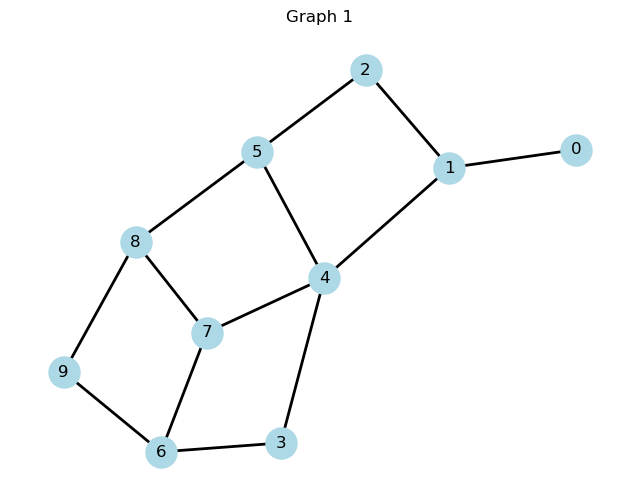

In [20]:
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrices['graph1'])

plt.figure(figsize=(8, 6))

# Set node positions
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

nx.draw_networkx_edges(G, pos, width=2)

nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.title("Graph 1")
plt.show()

### **Real data**

## **Complex example**

In [21]:
def symmetric_normalization(adj: torch.sparse.FloatTensor) -> torch.sparse.FloatTensor:
    """
    Applies symmetric normalization to the adjacency matrix: D^{-0.5} * A * D^{-0.5}.

    Parameters:
        adj (torch.sparse.FloatTensor): Sparse adjacency matrix.

    Returns:
        torch.sparse.FloatTensor: Symmetrically normalized adjacency matrix.
    """
    degree = torch.sum(adj, dim=1)
    degree_inv_sqrt = torch.pow(degree, -0.5)
    degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0.0

    D_inv_sqrt = torch.diag(degree_inv_sqrt)

    adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt

    return adj_normalized

In [22]:
unweighted_adjacency_matrix, node_to_index = prepare_directed_adjacency_matrix(edges_df)
weighted_adjacency_matrix, node_to_index = prepare_weighted_directed_adjacency_matrix(edges_df)
weighted_adjacency_matrix = symmetric_normalization(weighted_adjacency_matrix)
features_normalized

tensor([[ 0.3630, -0.3619,  0.3639, -0.3638,  0.9141],
        [ 0.3622, -0.3604,  0.3638, -0.3639,  1.3419],
        [ 0.3638, -0.3635,  0.3638, -0.3640,  0.9141],
        ...,
        [ 0.3628, -0.3616,  0.3638, -0.3641,  0.3412],
        [ 0.3668, -0.3696,  0.3639, -0.3638,  0.6516],
        [ 0.3626, -0.3611,  0.3638, -0.3639,  0.9141]])

In [23]:
check_symmetric(weighted_adjacency_matrix.numpy())

False

### **Clean version**

In [24]:
def run_complex_experiment(adjacency_matrix, feature_matrix, config):
    """
    Runs the experiment based on the provided configuration.

    Args:
        config (dict): Configuration dictionary containing hyperparameters and settings.
    """
    # Set random seeds
    random.seed(config.get('seed', 123))
    np.random.seed(config.get('seed', 123))
    torch.manual_seed(config.get('seed', 123))

    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32).to_sparse()

    feature_matrix = torch.tensor(feature_matrix, dtype=torch.float32)

    # Source, target, and K
    source_node = config['source_node']
    target_node = config['target_node']
    K = config['K']

    # Hyperparameters
    hidden_dim = config['hidden_dim']
    output_dim = config['output_dim']
    dropout = config['dropout']
    normalization = config.get('normalization', None)
    num_layers = config['num_layers']
    n_heads = config.get('n_heads', 4)
    num_epochs = config['num_epochs']
    learning_rate = config['learning_rate']
    device = config['device']
    chebyshev_k = config.get('chebyshev_k', None)
    residual = config.get('residual', True)
    concat = config.get('concat', True)

    # Choose the model type based on config
    model_type = config['model_type']
    print(f"Running experiment with {model_type}...\n")

    model_classes = {
        'Chebyshev GCN': ChebNetGCN,
        'Standard GCN': StackGCN,
        'GAT': GAT,
        'GNN': StackGNN,
    }

    model_class = model_classes[model_type]

    # Prepare additional model kwargs
    model_kwargs = {}
    if model_type == 'GAT':
        model_kwargs.update({'n_heads': n_heads, 'concat': concat,
                             'residual': residual})

    # Find Top K Paths using the unified function
    top_paths, _ = find_top_k_paths_unified(
        model_class=model_class,
        adj_matrix=adjacency_matrix,
        feature_matrix=feature_matrix,
        source=source_node,
        target=target_node,
        K=K,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout=dropout,
        normalization=normalization,
        num_layers=num_layers,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device,
        chebyshev_k=chebyshev_k,
        **model_kwargs
    )

    # Display the Top K Paths
    print("\nTop K Paths (Model):")
    for idx, (cost, path) in enumerate(top_paths, 1):
        print(f"Path {idx}: Cost = {cost:.4f}, Path = {path}")

    # return results
    return top_paths

config = {
    'seed': 123,
    'source_node': 0,
    'target_node': 5,
    'K': 3,
    'hidden_dim': 32,
    'output_dim': 1,
    'dropout': 0.1,
    'normalization': 'sym',
    'num_layers': 4,
    'n_heads': 8,
    'num_epochs': 100,
    'learning_rate': 0.1,
    'device': 'cpu',
    'chebyshev_k': None,
    'model_type': 'Standard GCN',  # Models: 'Chebyshev GCN', 'Standard GCN', 'GAT', 'GNN'
    'residual': True,
    'concat': True,
}

In [25]:
top_paths = run_complex_experiment(weighted_adjacency_matrix, features_normalized, config)

Running experiment with Standard GCN...

Epoch [1/100], Loss: 417.9355
Epoch [10/100], Loss: 361.1188
Epoch [20/100], Loss: 364.0569
Epoch [30/100], Loss: 360.3232
Epoch [40/100], Loss: 361.5439
Epoch [50/100], Loss: 357.4480
Epoch [60/100], Loss: 359.8126
Epoch [70/100], Loss: 358.6662
Epoch [80/100], Loss: 356.4189
Epoch [90/100], Loss: 361.3430
Epoch [100/100], Loss: 357.6216

Top K Paths (Model):
Path 1: Cost = 1.1183, Path = [0, 508, 912, 37, 911, 38, 919, 357, 5]
Path 2: Cost = 1.2860, Path = [0, 343, 764, 346, 608, 929, 37, 911, 38, 919, 357, 5]
Path 3: Cost = 1.5262, Path = [0, 343, 764, 346, 608, 929, 508, 912, 37, 911, 38, 919, 357, 5]


### **Detail version**

In [ ]:
# Define source and target nodes and K
# In this case we have node to index
source_node = 832
target_node = 20
K = 3


# Parameters for the experiment
hidden_dim = 32
output_dim = 1
dropout = 0.1
normalization = "sym"  # "sym" for symmetric normalization, "rw" for random walk
num_layers = 6  # 1 input, num_layers-2 hidden, 1 output
num_epochs = 100
n_heads = 4
learning_rate = 0.001
device = 'cpu'  # Change to 'cuda' if GPU is available
chebyshev_k = 2  # Set to None for standard GCN, or an integer for Chebyshev GCN
mod_type = "gat"  # Change to "conv", "gat", or "gnn
# Choose the model type based on chebyshev_k
if chebyshev_k is not None:
    model_type = "Chebyshev GCN"
elif mod_type == "conv":
    model_type = "Standard GCN"
elif mod_type == "gat":
    model_type = "GAT"
else:
    model_type = "GNN"

print(f"Running experiment with {model_type}...\n")
if chebyshev_k is not None:
  model_class=ChebNetGCN
elif mod_type == "conv":
  model_class=StackGCN
elif mod_type == "gat":
  model_class=GAT
else:
  model_class=StackGNN

# Prepare additional model kwargs
model_kwargs = {}
if model_type == 'GAT':
    model_kwargs.update({'n_heads': n_heads, 'concat': True})
# Find Top K Paths using the unified function
top_paths, _ = find_top_k_paths_unified(
    model_class=model_class,
    adj_matrix= weighted_adjacency_matrix, # unweighted_adjacency_matrix
    feature_matrix=features_normalized,
    source=source_node,
    target=target_node,
    K=K,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout,
    normalization=normalization,
    num_layers=num_layers,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    chebyshev_k=chebyshev_k,
    **model_kwargs
)

# Display the Top K Paths
print("\nTop K Paths:")
for idx, (cost, path) in enumerate(top_paths, 1):
    print(f"Path {idx}: Cost = {cost:.4f}, Path = {path}")


true_paths_with_scores = yen_top_k_shortest_paths(
                weighted_adjacency_matrix.numpy(),
                source_node,
                target_node,K)
true_paths = [path for _, path in true_paths_with_scores if path is not None]
# Process top_paths to ensure all paths are lists of integers
processed_top_paths = []
for cost, path in top_paths:
    # Ensure path is a list of integers
    path = [int(node) for node in path]
    processed_top_paths.append(path)

# Convert to set of tuples for comparison
found_path_set = set(tuple(p) for p in processed_top_paths)
true_path_set = set(tuple(p) for p in true_paths)

# Compute accuracy: Number of true paths found in top_paths
correct = len(true_path_set.intersection(found_path_set))
accuracy = correct / K if K > 0 else 0.0

print(accuracy)

Running experiment with Chebyshev GCN...

Epoch [1/100], Loss: 474.6319
Epoch [10/100], Loss: 450.5486
Epoch [20/100], Loss: 438.7483
Epoch [30/100], Loss: 425.6978
Epoch [40/100], Loss: 408.6789
Epoch [50/100], Loss: 388.8665
Epoch [60/100], Loss: 372.3163
Epoch [70/100], Loss: 362.3034
Epoch [80/100], Loss: 352.4254
Epoch [90/100], Loss: 358.5065
Epoch [100/100], Loss: 353.2840

Top K Paths:
Path 1: Cost = 3.2149, Path = [832, 248, 799, 807, 941, 10, 697, 11, 91, 626, 134, 17, 584, 138, 461, 42, 659, 914, 121, 660, 343, 0, 508, 912, 37, 911, 38, 919, 357, 240, 909, 31, 41, 866, 58, 20]
Path 2: Cost = 3.2348, Path = [832, 248, 799, 807, 941, 10, 631, 885, 17, 584, 138, 461, 42, 659, 914, 121, 660, 343, 0, 508, 912, 37, 911, 38, 919, 357, 240, 909, 31, 41, 866, 58, 20]
Path 3: Cost = 3.2629, Path = [832, 248, 799, 807, 941, 10, 697, 11, 91, 626, 134, 17, 584, 138, 461, 42, 659, 914, 121, 660, 343, 0, 508, 912, 37, 911, 38, 919, 357, 240, 260, 332, 126, 20]
0.6666666666666666


In [34]:
# Inverse mapping
index_to_node = {index: node_id for node_id, index in node_to_index.items()}

# Mapping from node id to name
node_id_place_name = dict(zip(nodes_df['node_id'], nodes_df['place_name']))

for cost, path in top_paths:
    node_ids = [index_to_node.get(index) for index in path]

    if None in node_ids:
        missing_indices = [path[i] for i, node_id in enumerate(node_ids) if node_id is None]
        print(f"Warning: Missing node IDs for indices {missing_indices}")
        continue
    place_names = [node_id_place_name.get(node_id,
                                          f'Unknown ({node_id})') for node_id in node_ids]

    # Display the path with place names
    path_str = ' -> '.join(place_names)
    print(f"Cost: {cost:.4f}, Path: {path_str}")


Cost: 1.1183, Path: Phở Việt Nam -> Hoang Ngoc 2 -> Tanpopo -> Hindu Temple -> Adora Art Hotel -> Pasteur Street Bewing Co -> Bảo Châu Laundry and Dry Cleaning -> Tòa án Nhân dân TP.HCM -> Nhà Hàng Nướng Barbecue Garden
Cost: 1.2860, Path: Phở Việt Nam -> Phạm Hồng Thái -> Lê Lai -> Lê Lai -> Khách Sạn Gia Huy -> Blessing Central Hotel -> Hindu Temple -> Adora Art Hotel -> Pasteur Street Bewing Co -> Bảo Châu Laundry and Dry Cleaning -> Tòa án Nhân dân TP.HCM -> Nhà Hàng Nướng Barbecue Garden
Cost: 1.5262, Path: Phở Việt Nam -> Phạm Hồng Thái -> Lê Lai -> Lê Lai -> Khách Sạn Gia Huy -> Blessing Central Hotel -> Hoang Ngoc 2 -> Tanpopo -> Hindu Temple -> Adora Art Hotel -> Pasteur Street Bewing Co -> Bảo Châu Laundry and Dry Cleaning -> Tòa án Nhân dân TP.HCM -> Nhà Hàng Nướng Barbecue Garden


In [35]:
def find_node_index(node_id_place_name, node_to_index, value):
    for key, val in node_id_place_name.items():
        if val == value:
            k = key
            if k in node_to_index:
                return node_to_index[k]
            else:
                return None


find_node_index(node_id_place_name, node_to_index, "The Coffee Bean & Tea Leaf")

832

In [36]:
# Invert node_to_index to get index_to_node
index_to_node = {index: node_id for node_id, index in node_to_index.items()}

place_name = "District 1, Ho Chi Minh City, Vietnam"
G = ox.graph_from_place(place_name, network_type='drive')
node_id_to_coords = {node_id: (data['y'], data['x']) for node_id, data in G.nodes(data=True)}

In [37]:
visualize_k_shortest_paths(top_paths,
                           index_to_node,
                           node_id_to_coords,
                           node_id_place_name)

Visualizing K-shortest paths...
K-shortest paths map saved as 'k_shortest_paths_map.html'. Open it in a web browser to view.


## **Full Comparison**

### **Define function**

In [33]:
def run_full_experiment():
    """
    Runs the experiment comparing Yen's algorithm, GCN, Chebyshev GCN, and GNN
    on randomly generated graphs (undirected and directed) with sizes 10, 30, 50 nodes.
    Metrics: Accuracy and Execution Time.
    """
    # Ensure random seeds are set for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    graph_sizes = [10, 30, 50, 100]
    graph_types = ['undirected', 'directed']
    K = 3  # Number of top paths to find

    results = []

    for graph_type in graph_types:
        for size in graph_sizes:
            print(f"\nGenerating {graph_type} graph with {size} nodes...")
            directed = True if graph_type == 'directed' else False

            # Generate a connected random graph
            adj_matrix_np = generate_connected_random_graph(
                num_nodes=size,
                directed=directed,
                edge_prob=0.3,
                weight_range=(1, 10)
            )

            # Convert adjacency matrix to torch sparse tensor
            adj_matrix = torch.from_numpy(adj_matrix_np).float()
            adj_matrix_sparse = adj_matrix.to_sparse()

            # Feature matrix: random features + degree
            degrees = adj_matrix_np.sum(axis=1)
            feature_matrix_np = np.hstack([
                np.random.randn(size, 2).astype(np.float32),  # Random features
                degrees[:, np.newaxis].astype(np.float32)     # Degree as an additional feature
            ])
            feature_matrix = torch.from_numpy(feature_matrix_np).float()

            # Select random source and target nodes
            source, target = random.sample(range(size), 2)
            print(f"Source node: {source}, Target node: {target}")

            # Generate true top K paths using Yen's Algorithm
            print("Generating true top K paths using Yen's Algorithm...")
            start_time = time.time()
            true_paths_with_scores = yen_top_k_shortest_paths(
                adj_matrix_np.copy(),
                source,
                target,
                K
            )
            yen_exec_time = time.time() - start_time

            true_paths = [path for _, path in true_paths_with_scores if path is not None]
            if len(true_paths) < K:
                print(f"Only found {len(true_paths)} paths. Adjusting K to {len(true_paths)}.")
                current_K = len(true_paths)
            else:
                current_K = K
            print(f"True paths: {true_paths}")

            # Define models to compare
            models = {
                'GCN': StackGCN,
                'Chebyshev GCN': ChebNetGCN,
                'GNN': StackGNN,
                'GAT': GAT
            }

            for model_name, model_class in models.items():
                print(f"\nRunning {model_name}...")
                chebyshev_k = 3 if model_name == 'Chebyshev GCN' else None
                
                model_kwargs = {}
                if model_name == 'GAT':
                    model_kwargs.update({'n_heads': 8, 'concat': True})

                # Find top K paths using the unified function
                top_paths, exec_time = find_top_k_paths_unified(
                    model_class=model_class,
                    adj_matrix=adj_matrix_sparse,
                    feature_matrix=feature_matrix,
                    source=source,
                    target=target,
                    K=current_K,
                    hidden_dim=32,
                    output_dim=1,
                    dropout=0.1,
                    normalization="sym",
                    num_layers=4,
                    num_epochs=100,
                    learning_rate=0.01,
                    device='cpu',
                    chebyshev_k=chebyshev_k,
                    **model_kwargs
                )

                # Process top_paths to ensure all paths are lists of integers
                processed_top_paths = []
                for cost, path in top_paths:
                    # Ensure path is a list of integers
                    path = [int(node) for node in path]
                    processed_top_paths.append(path)

                # Convert to set of tuples for comparison
                found_path_set = set(tuple(p) for p in processed_top_paths)
                true_path_set = set(tuple(p) for p in true_paths)

                # Compute accuracy: Number of true paths found in top_paths
                correct = len(true_path_set.intersection(found_path_set))
                accuracy = correct / current_K if current_K > 0 else 0.0

                # Store results
                results.append({
                    'Graph Type': graph_type,
                    'Graph Size': size,
                    'Model': model_name,
                    'Accuracy': accuracy * 100,  # Convert to percentage
                    'Execution Time (s)': exec_time
                })

                print(f"{model_name} - Accuracy: {accuracy*100:.2f}%, Execution Time: {exec_time:.4f} seconds")
                print(f"Found paths: {processed_top_paths}")

    results_df = pd.DataFrame(results)

    # Display
    print("\n\n=== Experiment Results ===")
    print("{:<12} {:<10} {:<15} {:<10} {:<20}".format('Graph Type', 'Size', 'Model', 'Accuracy', 'Execution Time (s)'))
    for res in results:
        print("{:<12} {:<10} {:<15} {:<10.2f} {:<20.4f}".format(
            res['Graph Type'],
            res['Graph Size'],
            res['Model'],
            res['Accuracy'],
            res['Execution Time (s)']
        ))

    return results_df

### **Run experiment**

In [34]:
res_df = run_full_experiment()


Generating undirected graph with 10 nodes...
Source node: 2, Target node: 4
Generating true top K paths using Yen's Algorithm...
True paths: [[2, 1, 9, 4], [2, 1, 0, 4], [2, 1, 6, 4]]

Running GCN...
Epoch [1/100], Loss: 60.2408
Epoch [10/100], Loss: 7.7452
Epoch [20/100], Loss: 6.0928
Epoch [30/100], Loss: 1.2903
Epoch [40/100], Loss: 0.9109
Epoch [50/100], Loss: 0.9402
Epoch [60/100], Loss: 0.9402
Epoch [70/100], Loss: 0.8455
Epoch [80/100], Loss: 0.8587
Epoch [90/100], Loss: 0.7075
Epoch [100/100], Loss: 0.5824
GCN - Accuracy: 100.00%, Execution Time: 0.6945 seconds
Found paths: [[2, 1, 0, 4], [2, 1, 9, 4], [2, 1, 6, 4]]

Running Chebyshev GCN...
Epoch [1/100], Loss: 481.8019
Epoch [10/100], Loss: 35.2327
Epoch [20/100], Loss: 3.7057
Epoch [30/100], Loss: 12.8081
Epoch [40/100], Loss: 0.8011
Epoch [50/100], Loss: 0.8359
Epoch [60/100], Loss: 0.5435
Epoch [70/100], Loss: 0.2344
Epoch [80/100], Loss: 0.2192
Epoch [90/100], Loss: 0.3502
Epoch [100/100], Loss: 0.2086
Chebyshev GCN - Ac

In [35]:
res_df

,Graph Type,Graph Size,Model,Accuracy,Execution Time (s)
0,undirected,10,GCN,100.000000,0.694543
1,undirected,10,Chebyshev GCN,100.000000,0.770907
2,undirected,10,GNN,66.666667,0.860883
3,undirected,10,GAT,100.000000,2.799968
4,undirected,30,GCN,100.000000,1.274493
5,undirected,30,Chebyshev GCN,100.000000,1.300988
6,undirected,30,GNN,100.000000,1.534029
7,undirected,30,GAT,100.000000,4.010408
8,undirected,50,GCN,66.666667,1.299468
9,undirected,50,Chebyshev GCN,66.666667,1.446710


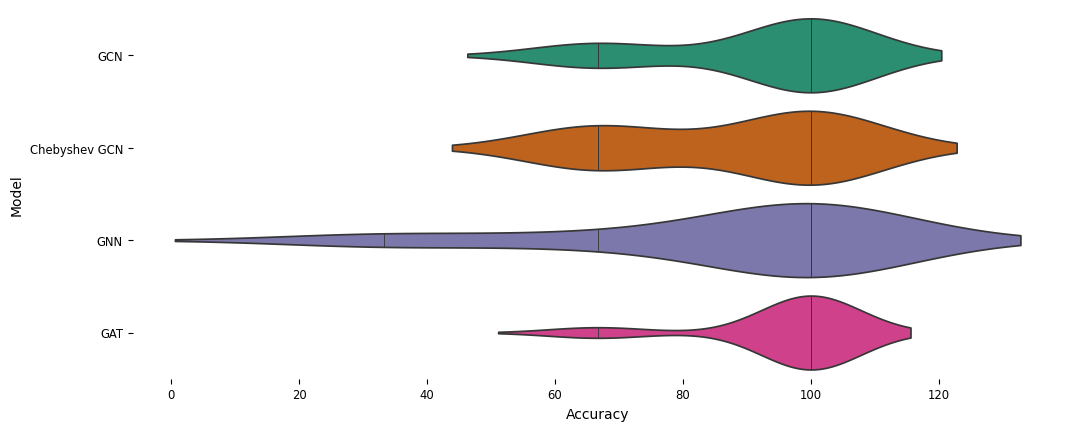

In [36]:
figsize = (12, 1.2 * len(res_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_df, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.savefig('acc_model.pdf', dpi=300, bbox_inches='tight')


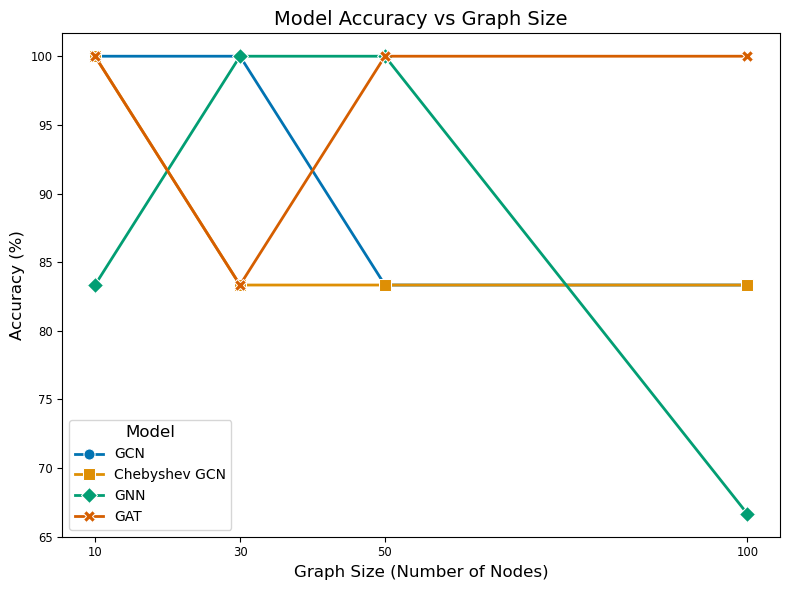

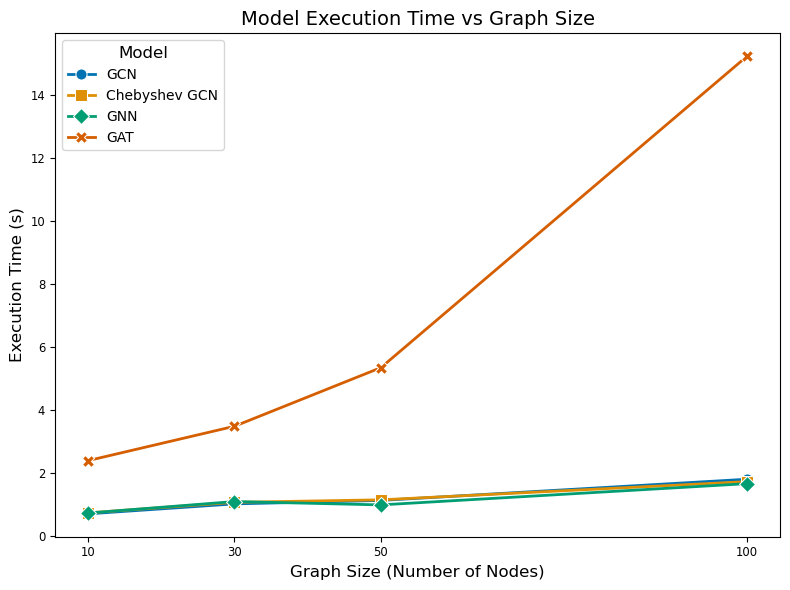

In [37]:
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'small',
         'ytick.labelsize': 'small'
         }

def stylize_axes(ax, title):
    """
    Stylize the axes by removing ths spines and ticks.
    """
    # removes the top and right lines from the plot rectangle
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)

    # Enforce the size of the title, label and tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')

    ax.set_yticklabels(ax.get_yticklabels(), fontsize='medium')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='medium')

    ax.set_title(title, fontsize='large')

def save_image(fig, title):
    """
    Save the figure as PNG and pdf files
    """
    if title is not None:
        fig.savefig(title+".png", dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig(title+".pdf", bbox_inches='tight')

# sns.set(style='whitegrid')
sns.set_context(rc=params)

color_palette = sns.color_palette('colorblind')

marker_styles = {'GCN': 'o', 'Chebyshev GCN': 's', 'GNN': 'D', 'GAT': 'X'}
# Plotting Accuracy
plt.figure(figsize=(8, 6))
graph_sizes = [10, 30, 50, 100]
plt.xticks(graph_sizes)

# Plot the data
sns.lineplot(
    data=res_df,
    x='Graph Size',
    y='Accuracy',
    hue='Model',
    style='Model',
    markers=marker_styles,
    dashes=False,
    palette=color_palette,
    markersize=8,
    linewidth=2,
    ci=None
)

# Set plot title and labels
plt.title('Model Accuracy vs Graph Size', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Graph Size (Number of Nodes)', fontsize=12)

plt.legend(title='Model', fontsize=10, title_fontsize=12, loc='best')
plt.tight_layout()
plt.savefig('accuracy_vs_graph_size.pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.xticks(graph_sizes)

# Plot the data
sns.lineplot(
    data=res_df,
    x='Graph Size',
    y='Execution Time (s)',
    hue='Model',
    style='Model',
    markers=marker_styles,
    dashes=False,
    palette=color_palette,
    markersize=8,
    linewidth=2,
    ci=None
)

# Set plot title and labels
plt.title('Model Execution Time vs Graph Size', fontsize=14)
plt.ylabel('Execution Time (s)', fontsize=12)
plt.xlabel('Graph Size (Number of Nodes)', fontsize=12)

plt.legend(title='Model', fontsize=10, title_fontsize=12, loc='best')

plt.tight_layout()

plt.savefig('execution_time_vs_graph_size.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()